# Python DL_NLP Crash Course_Part 5: Language Modelling with LSTM

## Full Day Workshop for user learn Data Science with Python
### 2017 Dec Timothy CL Lam
This is meant for internal usage, part of contents copied externally, not for commercial purpose


In [3]:
# The code was removed by DSX for sharing.

,YEAR,QUARTER,QUARTER_YEAR,CHURN_RATE
0,2014,1,1Q14,18.1
1,2014,2,2Q14,18.7
2,2014,3,3Q14,19.3
3,2014,4,4Q14,19.9
4,2015,1,1Q15,20.5


## Language Model
- A language model predicts the next word in the sequence based on the specic words that have
come before it in the sequence. 

# Character-Based Neural Language Model

- It is possible to develop language models at the character
level using neural networks. 
- The benefit of character-based language models is their small
vocabulary and 
exibility in handling any words, punctuation, and other document structure.
- This comes at the cost of requiring larger models that are slower to train.

# Sing a song of Experience
- The nursery rhyme Sing a Song of Sixpence is well known in the west. 
- The first verse is common,
but there is also a 4 verse version that we will use to develop our character-based language
model.

In [1]:
Sing a song of sixpence,
A pocket full of rye.
Four and twenty blackbirds,
Baked in a pie.
When the pie was opened
The birds began to sing;
Wasn't that a dainty dish,
To set before the king.
The king was in his counting house,
Counting out his money;
The queen was in the parlour,
Eating bread and honey.
The maid was in the garden,
Hanging out the clothes,
When down came a blackbird
And pecked off her nose.

SyntaxError: invalid syntax (<ipython-input-1-67d65fddc005>, line 1)

# Data Preparation
## Language Model Design
- A language model must be trained on the text, and in the case of a character-based language
model, the input and output sequences must be characters. 
- The number of characters used
as input will also define the number of characters that will need to be provided to the model
in order to elicit the first predicted character.
- Longer sequences oer more context for the model to learn what character to output next
but take longer to train and impose more burden on seeding the model when generating text.
- We will use an arbitrary length of 10 characters for this model.

#### We must load the text into memory so that we can work with it. Below is a function named load doc()

In [6]:
# load doc into memory
def load_doc(file):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [7]:
# The code was removed by DSX for sharing.

In [8]:
import requests, StringIO, pandas as pd, json, re

In [105]:
def get_file_content(credentials):
    """For given credentials, this functions returns a StringIO object containing the file content."""
    
    url1 = ''.join([credentials['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()    
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                if(e2['interface']=='public'and e2['region']==credentials['region']):
                    url2 = ''.join([e2['url'],'/', credentials['container'], '/', credentials['filename']])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO.StringIO(resp2.content)

In [106]:
content_string = get_file_content(credentials_1)
raw_text = content_string.getvalue()
print raw_text

In [107]:
raw_text = raw_text[:-3]

In [108]:
raw_text[:]

"Sing a song of sixpence,\rA pocket full of rye.\rFour and twenty blackbirds,\rBaked in a pie.\rWhen the pie was opened\rThe birds began to sing;\rWasn' t that a dainty dish,\rTo set before the king.\rThe king was in his counting house,\rCounting out his money;\rThe queen was in the parlour,\rEating bread and honey.\rThe maid was in the garden,\rHanging out the clothes,\rWhen down came a blackbird\rAnd pecked off her nose"

## Clean Text
- we will strip all of the new line characters 
- so that we have one long sequence of characters
separated only by white space.

In [148]:
# clean
tokens = raw_text.split()
raw_text = ' '.join(tokens)

In [149]:
raw_text[:]

"Sing a song of sixpence, A pocket full of rye. Four and twenty blackbirds, Baked in a pie. When the pie was opened The birds began to sing; Wasn' t that a dainty dish, To set before the king. The king was in his counting house, Counting out his money; The queen was in the parlour, Eating bread and honey. The maid was in the garden, Hanging out the clothes, When down came a blackbird And pecked off her nose"

### Tips
- You may want to explore other methods for data cleaning, 
- such as normalizing the case to
lowercase or removing punctuation in an effort 
- to reduce the final vocabulary size and develop a
smaller and leaner model.

## Create Sequences
- Now that we have a long list of characters, 
- we can create our input-output sequences used to
train the model. 
- Each input sequence will be 10 characters with one output character, 
- making
each sequence 11 characters long

In [150]:
# organize into sequences of characters
chars = sorted(list(set(raw_text)))
mapping = dict((c, i) for i, c in enumerate(chars))
length = 10


In [151]:
sequences = list()
for i in range(length, len(raw_text)):
    # select sequence of tokens
    seq = raw_text[i-length:i+1]
    # store
    sequences.append(seq)
print('Total Sequences: %d' % len(sequences))


Total Sequences: 399


#### We can create the sequences by enumerating the characters in the text, starting at the 11th character at index 10.

In [152]:
sequences[:]

['Sing a song',
 'ing a song ',
 'ng a song o',
 'g a song of',
 ' a song of ',
 'a song of s',
 ' song of si',
 'song of six',
 'ong of sixp',
 'ng of sixpe',
 'g of sixpen',
 ' of sixpenc',
 'of sixpence',
 'f sixpence,',
 ' sixpence, ',
 'sixpence, A',
 'ixpence, A ',
 'xpence, A p',
 'pence, A po',
 'ence, A poc',
 'nce, A pock',
 'ce, A pocke',
 'e, A pocket',
 ', A pocket ',
 ' A pocket f',
 'A pocket fu',
 ' pocket ful',
 'pocket full',
 'ocket full ',
 'cket full o',
 'ket full of',
 'et full of ',
 't full of r',
 ' full of ry',
 'full of rye',
 'ull of rye.',
 'll of rye. ',
 'l of rye. F',
 ' of rye. Fo',
 'of rye. Fou',
 'f rye. Four',
 ' rye. Four ',
 'rye. Four a',
 'ye. Four an',
 'e. Four and',
 '. Four and ',
 ' Four and t',
 'Four and tw',
 'our and twe',
 'ur and twen',
 'r and twent',
 ' and twenty',
 'and twenty ',
 'nd twenty b',
 'd twenty bl',
 ' twenty bla',
 'twenty blac',
 'wenty black',
 'enty blackb',
 'nty blackbi',
 'ty blackbir',
 'y blackbird',
 ' black

In [153]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
# save sequences to file
out_filename = 'char_sequences.txt'
save_doc(sequences, out_filename)

## Train Language Model
- Coming section is to develop a neural language model for the prepared sequence data. 
- The
model will read encoded characters and predict the next character in the sequence.
- A Long
Short-Term Memory recurrent neural network hidden layer will be used 
- to learn the context
from the input sequence in order to make the predictions.

In [154]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load
in_filename = 'char_sequences.txt'
raw_text = load_doc(in_filename)
lines = raw_text.split('\n')

In [156]:
from numpy import array
from pickle import dump
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

## Encode Sequences
- The sequences of characters must be encoded as integers. 
- This means that each unique character
will be assigned a specific integer value and each sequence of characters will be encoded as a
sequence of integers. 
- We can create the mapping given a sorted set of unique characters in the
raw input data. 
- The mapping is a dictionary of character values to integer values.

In [157]:
# integer encode sequences of characters
chars = sorted(list(set(raw_text)))
mapping = dict((c, i) for i, c in enumerate(chars))

## Character Mapping & Vocab Size
- Next, we can process each sequence of characters one at a time 
- and use the dictionary mapping to look up the integer value for each character
- The result is a list of integer lists. 
- We need to know the size of the vocabulary later.

In [158]:
sequences = list()
for line in lines:
    # integer encode line
    encoded_seq = [mapping[char] for char in line]
    # store
    sequences.append(encoded_seq)
# vocabulary size
vocab_size = len(mapping)
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 38


## Define Input & output
- Now that the sequences have been integer encoded, 
- we can separate the columns into input and
output sequences of characters. 
- We can do this using a simple array slice.

In [159]:
# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
sequences = [to_categorical(x, num_classes=vocab_size) for x in X]
X = array(sequences)
y = to_categorical(y, num_classes=vocab_size)



## One Hot Encoded
- Next, we need to one hot encode each character.
- That is, each character becomes a vector as
long as the vocabulary (38 elements) 
- with a 1 marked for the specic character. 
- This provides
a more precise input representation for the network.

## LSTM Model Setting
- The model is defined with an input layer that takes sequences that have 10 time steps and 38
features for the one hot encoded input sequences. 
- Rather than specify these numbers, we use
the second and third dimensions on the X input data. 
- This is so that if we change the length of
the sequences or size of the vocabulary, we do not need to change the model definition. 
- The
model has a single LSTM hidden layer with 75 memory cells, chosen with a little trial and
error. 
- The model has a fully connected output layer that outputs one vector with a probability
distribution across all characters in the vocabulary. 
- A softmax activation function is used on
the output layer to ensure the output has the properties of a probability distribution.

In [160]:
# define the model
def define_model(X):
    model = Sequential()
    model.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(vocab_size, activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Evaluate the Model
- The model is learning a multiclass classification problem, 
- therefore we use the categorical log
loss intended for this type of problem. 
- The efficient Adam implementation of gradient descent
is used to optimize the model and accuracy is reported at the end of each batch update.

In [161]:
# define model
model = define_model(X)
# fit model
model.fit(X, y, epochs=100, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 75)                34200     
_________________________________________________________________
dense_4 (Dense)              (None, 38)                2888      
Total params: 37,088
Trainable params: 37,088
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 - 2s - loss: 3.6097 - acc: 0.1228
Epoch 2/100
 - 0s - loss: 3.4844 - acc: 0.1930
Epoch 3/100
 - 0s - loss: 3.1846 - acc: 0.1930
Epoch 4/100
 - 0s - loss: 3.0560 - acc: 0.1930
Epoch 5/100
 - 0s - loss: 3.0179 - acc: 0.1930
Epoch 6/100
 - 0s - loss: 2.9946 - acc: 0.1930
Epoch 7/100
 - 0s - loss: 2.9800 - acc: 0.1930
Epoch 8/100
 - 0s - loss: 2.9648 - acc: 0.1930
Epoch 9/100
 - 0s - loss: 2.9536 - acc: 0.1930
Epoch 10/100
 - 0s - loss: 2.9390 - acc: 0.1930
Epoch 11/100
 - 0s - loss: 2.9258 - acc: 0.1930
Epoch 12/100
 -

## Save Model
- After the model is fit, we save it to file for later use. 
- The Keras model API provides the save()
function that we can use to save the model to a single file, 
- including weights and topology
information.

In [20]:
!pip install h5py

In [21]:
import h5py

In [162]:
# save the model to file
model.save('model.h5py')

## Save Mapping
- We also save the mapping from characters to integers that 
- we will need to encode any input
when using the model and decode any output from the model

In [163]:
# save the mapping
dump(mapping, open('mapping.pkl', 'wb'))

# Generate Text
- We will use the learned language model to generate new sequences of text that have the same statistical properties.

## Load Model & Mapping
- The first step is to load the model saved to the le model.h5. We can use the load model() function from the Keras API.
- We also need to load the pickled dictionary for mapping characters to integers from the le
- mapping.pkl. We will use the Pickle API to load the object.

In [164]:
from pickle import load
from keras.models import load_model
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [170]:
# load the model
model = load_model('model.h5')

# load the mapping
mapping = load(open('mapping.pkl', 'rb'))

## Generate Characters
- We must provide sequences of 10 characters as input to the model in order to start the generation process. We will pick these manually
- First, the sequence of characters must
be integer encoded using the loaded mapping.

In [39]:
# encode the characters as integers
# encoded = [mapping[char] for char in in_text]

## ENcode & 3 Dimension
- Next, the integers need to be one hot encoded using the to categorical() Keras function.
- We also need to reshape the sequence to be 3-dimensional, as we only have one sequence and
- LSTMs require all input to be three dimensional (samples, time steps, features).

In [40]:
# one hot encode
# encoded = to_categorical(encoded, num_classes=len(mapping))
# encoded = encoded.reshape(1, encoded.shape[0], encoded.shape[1])

## Predict
- We can then use the model to predict the next character in the sequence. 
- We use
predict classes() instead of predict() to directly select the integer for the character with
the highest probability
- instead of getting the full probability distribution across the entire set of
characters.

In [41]:
# predict character
# yhat = model.predict_classes(encoded, verbose=0)

## Decode & Pad
- We can then decode this integer by looking up the mapping to see the character to which it maps.
- This character can then be added to the input sequence. We then need to make sure that the
input sequence is 10 characters by truncating the rst character from the input sequence text.
- We can use the pad sequences() function from the Keras API that can perform this truncation
operation. 
- Putting all of this together, we can dene a new function named generate seq()
for using the loaded model to generate new sequences of text

In [166]:
# generate a sequence of characters with a language model
def generate_seq(model, mapping, seq_length, seed_text, n_chars):
    in_text = seed_text
    # generate a fixed number of characters
    for _ in range(n_chars):
        # encode the characters as integers
        encoded = [mapping[char] for char in in_text]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # one hot encode
        encoded = to_categorical(encoded, num_classes=len(mapping))
        encoded = encoded.reshape(1, encoded.shape[0], encoded.shape[1])
        # predict character
        yhat = model.predict_classes(encoded, verbose=0)
        # reverse map integer to character
        out_char = ''
        for char, index in mapping.items():
            if index == yhat:
                out_char = char
                break
    # append to input
    in_text += char
    return in_text

In [171]:
# load the model
model = load_model('model.h5')
# load the mapping
mapping = load(open('mapping.pkl', 'rb'))


In [174]:
# test start of rhyme
print(generate_seq(model, mapping, 10, 'Sing a son', 20))
# test mid-line
print(generate_seq(model, mapping, 10, 'king was i', 20))
# test not in original
print(generate_seq(model, mapping, 10, 'hello worl', 20))

ValueError: cannot reshape array of size 380 into shape (1,1,10)

# Word-Based Neural Language Model
## Framing Language Modeling

_* A statistical language model is learned from raw text and predicts the probability of the next word in the sequence given the words already present in the sequence. *_

Language models are a key component in larger models for challenging natural language processing problems, like machine translation and speech recognition. They can also be developed as standalone models and used for generating new sequences that have the same statistical properties as the source text.

Language models both learn and predict one word at a time. The training of the network involves providing sequences of words as input that are processed one at a time where a prediction can be made and learned for each input sequence.

Similarly, when making predictions, the process can be seeded with one or a few words, then predicted words can be gathered and presented as input on subsequent predictions in order to build up a generated output sequence

Therefore, each model will involve splitting the source text into input and output sequences, such that the model can learn to predict words.



In [1]:
# Sample Text being anlayzed:


# source text
data = """ Jack and Jill went up the hill\n
		To fetch a pail of water\n
		Jack fell down and broke his crown\n
		And Jill came tumbling after\n """

## Model 1: One-Word-In, One-Word-Out Sequences 
We can start with a very simple model.

Given one word as input, the model will learn to predict the next word in the sequence.

Keras provides the Tokenizer class that can be used to perform this encoding. First, the Tokenizer is fit on the source text to develop the mapping from words to unique integers. Then sequences of text can be converted to sequences of integers by calling the texts_to_sequences() function.

In [2]:
from keras.preprocessing.text import Tokenizer


# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0]

# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

/gpfs/fs01/user/sbb6-28ae32a56257b0-666d72869b6d/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Vocabulary Size: 22


In [25]:
encoded[:]

[2,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 2,
 14,
 15,
 1,
 16,
 17,
 18,
 1,
 3,
 19,
 20,
 21]

We add one, because we will need to specify the integer for the largest encoded word as an array index, e.g. words encoded 1 to 21 with array indicies 0 to 21 or 22 positions.

Next, we need to create sequences of words to fit the model with one word as input and one word as output.

Running this piece shows that we have a total of 24 input-output pairs to train the network.

In [26]:
import array

In [27]:
# create word -> word sequences
sequences = list()
for i in range(1, len(encoded)):
	sequence = encoded[i-1:i+1]
	sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

#We can then split the sequences into input (X) and output elements (y). This is straightforward as we only have two columns in the data.





Total Sequences: 24


In [28]:
sequences[:]

[[2, 1],
 [1, 3],
 [3, 4],
 [4, 5],
 [5, 6],
 [6, 7],
 [7, 8],
 [8, 9],
 [9, 10],
 [10, 11],
 [11, 12],
 [12, 13],
 [13, 2],
 [2, 14],
 [14, 15],
 [15, 1],
 [1, 16],
 [16, 17],
 [17, 18],
 [18, 1],
 [1, 3],
 [3, 19],
 [19, 20],
 [20, 21]]

In [29]:
# split into X and y elements
sequences = np.array(sequences)
X, y = sequences[:,0],sequences[:,1]


NameError: name 'np' is not defined

We will fit our model to predict a probability distribution across all words in the vocabulary. That means that we need to turn the output element from a single integer into a one hot encoding with a 0 for every word in the vocabulary and a 1 for the actual word that the value. This gives the network a ground truth to aim for from which we can calculate error and update the model.

Keras provides the to_categorical() function that we can use to convert the integer to a one hot encoding while specifying the number of classes as the vocabulary size.

In [ ]:
from keras.utils import to_categorical

In [ ]:
# one hot encode outputs
y = to_categorical(y, num_classes=vocab_size)

We are now ready to define the neural network model.

The model uses a learned word embedding in the input layer. This has one real-valued vector for each word in the vocabulary, where each word vector has a specified length. In this case we will use a 10-dimensional projection. The input sequence contains a single word, therefore the input_length=1.

The model has a single hidden LSTM layer with 50 units. This is far more than is needed. The output layer is comprised of one neuron for each word in the vocabulary and uses a softmax activation function to ensure the output is normalized to look like a probability.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM

In [ ]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

We will use this same general network structure for each example in this tutorial, with minor changes to the learned embedding layer.

Next, we can compile and fit the network on the encoded text data. Technically, we are modeling a multi-class classification problem (predict the word in the vocabulary), therefore using the categorical cross entropy loss function. We use the efficient Adam implementation of gradient descent and track accuracy at the end of each epoch. The model is fit for 500 training epochs, again, perhaps more than is needed.

The network configuration was not tuned for this and later experiments; an over-prescribed configuration was chosen to ensure that we could focus on the framing of the language model.

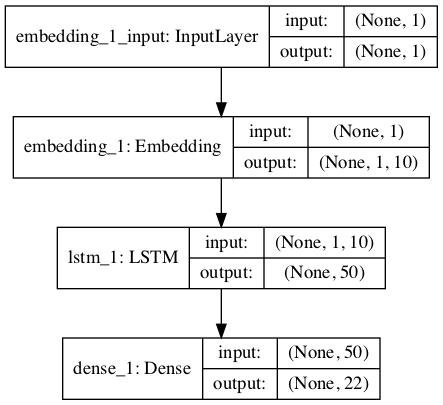

In [ ]:

# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X, y, epochs=500, verbose=2)

After the model is fit, we test it by passing it a given word from the vocabulary and having the model predict the next word. Here we pass in ‘Jack‘ by encoding it and calling model.predict_classes() to get the integer output for the predicted word. This is then looked up in the vocabulary mapping to give the associated word.

This process could then be repeated a few times to build up a generated sequence of words.

To make this easier, we wrap up the behavior in a function that we can call by passing in our model and the seed word.

In [ ]:
# evaluate
in_text = 'Jack'
print(in_text)
encoded = tokenizer.texts_to_sequences([in_text])[0]
encoded = np.array(encoded)
yhat = model.predict_classes(encoded, verbose=0)
for word, index in tokenizer.word_index.items():
	if index == yhat:
		print(word)

In [ ]:
def generate_seq(model, tokenizer, seed_text, n_words):
	in_text, result = seed_text, seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		encoded = np.array(encoded)
		# predict a word in the vocabulary
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text, result = out_word, result + ' ' + out_word
	return result

In [ ]:
print(generate_seq(model, tokenizer, 'Jack', 6))

This is a good first cut language model, but does not take full advantage of the LSTM’s ability to handle sequences of input and disambiguate some of the ambiguous pairwise sequences by using a broader context.

#  Model 2: Line-by-Line Sequence

Another approach is to split up the source text line-by-line, then break each line down into a series of words that build up.

In [ ]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [ ]:
# Something like that:
#X,									y
#_, _, _, _, _, Jack, 				and
#_, _, _, _, Jack, and 				Jill
#_, _, _, Jack, and, Jill,			went
#_, _, Jack, and, Jill, went,		up
#_, Jack, and, Jill, went, up,		the
#Jack, and, Jill, went, up, the,		hill

This approach may allow the model to use the context of each line to help the model in those cases where a simple one-word-in-and-out model creates ambiguity.

In this case, this comes at the cost of predicting words across lines, which might be fine for now if we are only interested in modeling and generating lines of text.

Note that in this representation, we will require a padding of sequences to ensure they meet a fixed length input. This is a requirement when using Keras.

First, we can create the sequences of integers, line-by-line by using the Tokenizer already fit on the source text.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# create line-based sequences
sequences = list()
for line in data.split('\n'):
	encoded = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(encoded)):
		sequence = encoded[:i+1]
		sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

Next, we can pad the prepared sequences. We can do this using the pad_sequences() function provided in Keras. This first involves finding the longest sequence, then using that as the length by which to pad-out all other sequences.

In [ ]:

# pad input sequences
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)

## Next, we can split the sequences into input and output elements, much like before.

In [ ]:
# split into input and output elements
sequences = array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

The model can then be dened as before, except the input sequences are now longer than a
single word. Specically, they are max length-1 in length, -1 because when we calculated the
maximum length of sequences, they included the input and output elements.

In [ ]:
# define the model
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length-1))
    model.add(LSTM(50))
    model.add(Dense(vocab_size, activation='softmax'))
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

We can use the model to generate new sequences as before. The generate seq() function
can be updated to build up an input sequence by adding predictions to the list of input words
each iteration.

In [ ]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # pre-pad sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
    return in_text

Running the example achieves a better t on the source data. The added context has allowed
the model to disambiguate some of the examples. There are still two lines of text that start
with \Jack" that may still be a problem for the network.

In [ ]:
# define model
model = define_model(vocab_size, max_length)
# fit network
model.fit(X, y, epochs=500, verbose=2)
# evaluate model


In [ ]:
print(generate_seq(model, tokenizer, max_length-1, 'Jack', 4))
print(generate_seq(model, tokenizer, max_length-1, 'Jill', 4))

At the end of the run, we generate two sequences with dierent seed words: Jack and Jill.
The rst generated line looks good, directly matching the source text. The second is a bit
strange. This makes sense, because the network only ever saw Jill within an input sequence,
not at the beginning of the sequence, so it has forced an output to use the word Jill

#

## Model 3: Two-Words-In, One-Word-Out Sequence

We can use an intermediate between the one-word-in and the whole-sentence-in approaches
and pass in a sub-sequences of words as input. This will provide a trade-o between the two
framings allowing new lines to be generated and for generation to be picked up mid line. We will
use 3 words as input to predict one word as output. The preparation of the sequences is much
like the rst example, except with dierent osets in the source sequence arrays, as follows:

In [ ]:
# encode 2 words -> 1 word
sequences = list()
for i in range(2, len(encoded)):
    sequence = encoded[i-2:i+1]
    sequences.append(sequence)
    print('Total Sequences: %d' % len(sequences))

In [ ]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, max_length, seed_text, n_words):
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # pre-pad sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
    return in_text


In [ ]:
# define the model
def define_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length-1))
    model.add(LSTM(50))
    model.add(Dense(vocab_size, activation='softmax'))
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded = tokenizer.texts_to_sequences([data])[0]
# retrieve vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# encode 2 words -> 1 word
sequences = list()
for i in range(2, len(encoded)):
    sequence = encoded[i-2:i+1]
    sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))
# pad sequences
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)
# split into input and output elements
sequences = array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
# define model
model = define_model(vocab_size, max_length)
# fit network
model.fit(X, y, epochs=500, verbose=2)

In [ ]:
# evaluate model
print(generate_seq(model, tokenizer, max_length-1, 'Jack and', 5))
print(generate_seq(model, tokenizer, max_length-1, 'And Jill', 3))
print(generate_seq(model, tokenizer, max_length-1, 'fell down', 5))
print(generate_seq(model, tokenizer, max_length-1, 'pail of', 5))

## Summary
The first start of line case generated correctly, but the second did not. The second case was
an example from the 4th line, which is ambiguous with content from the rst line. Perhaps a
further expansion to 3 input words would be better. The two mid-line generation examples were
generated correctly, matching the source text.
We can see that the choice of how the language model is framed and the requirements on
how the model will be used must be compatible. That careful design is required when using
language models in general, perhaps followed-up by spot testing with sequence generation to
conrm model requirements have been met.